<a href="https://colab.research.google.com/github/hannamesquita/trabalhoFIA2/blob/main/TFIA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install LTNtorch


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import ltn
import numpy as np
import matplotlib.pyplot as plt

# Configura o LTNtorch para usar o dispositivo (GPU se disponível)
ltn.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {ltn.device}")

Usando dispositivo: cpu


In [5]:
class CNN_model(nn.Module):
    """Define uma CNN simples para classificação de imagens."""
    def __init__(self):
        super(CNN_model, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Sigmoid força a saída para [0, 1]
        )

    def forward(self, x):
        return self.net(x)

print("Modelo CNN definido com sucesso!")

Modelo CNN definido com sucesso!


In [6]:
N = 100
img_size = (3, 32, 32)

# Gera imagens aleatórias para cães e gatos
dog_imgs = torch.rand((N,) + img_size).to(ltn.device)
cat_imgs = torch.rand((N,) + img_size).to(ltn.device)

print(f"Dados gerados:")
print(f"  - Imagens de cães: {dog_imgs.shape}")
print(f"  - Imagens de gatos: {cat_imgs.shape}")

Dados gerados:
  - Imagens de cães: torch.Size([100, 3, 32, 32])
  - Imagens de gatos: torch.Size([100, 3, 32, 32])


In [7]:
class DogCatDataset(Dataset):
    def __init__(self, dogs, cats):
        self.dogs = dogs
        self.cats = cats

    def __len__(self):
        return min(len(self.dogs), len(self.cats))

    def __getitem__(self, idx):
        return self.dogs[idx], self.cats[idx]

# Cria o dataset e dataloader
dataset = DogCatDataset(dog_imgs, cat_imgs)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Dataset criado com {len(dataset)} pares de imagens")
print(f"Número de batches: {len(train_dataloader)}")

Dataset criado com 100 pares de imagens
Número de batches: 7


In [8]:
# Define o predicado Dog
Dog = ltn.Predicate(CNN_model().to(ltn.device))

# Define os operadores lógicos
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")

# SatAgg (Agregador de Satisfação)
SatAgg = ltn.fuzzy_ops.SatAgg()

# Otimizador
optimizer = torch.optim.Adam(Dog.parameters(), lr=0.001)

print("Predicado Dog e operadores lógicos definidos!")
print(f"Parâmetros do modelo: {sum(p.numel() for p in Dog.parameters())}")

Predicado Dog e operadores lógicos definidos!
Parâmetros do modelo: 196737


In [9]:
nepochs = 20

print("Iniciando treinamento...\n")
for epoch in range(nepochs):
    train_loss = 0.0

    for i, (dog_batch, cat_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Ground logical variables with current training batch
        dogs = ltn.Variable("dogs", dog_batch)  # positive examples
        cats = ltn.Variable("cats", cat_batch)  # negative examples

        # Compute loss function
        # Axioma 1: Para todo dog, Dog(dog) deve ser verdadeiro
        axiom_dogs = Forall(dogs, Dog(dogs))  # this is phi_1

        # Axioma 2: Para todo cat, Not(Dog(cat)) deve ser verdadeiro
        axiom_cats = Forall(cats, Not(Dog(cats)))  # this is phi_2

        # Calcula a satisfação total
        sat = SatAgg(axiom_dogs, axiom_cats)

        # Calcula a perda
        loss = 1.0 - sat

        # Back-propagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_dataloader)

    if epoch % 2 == 0 or epoch == nepochs - 1:
        print(f"Epoch {epoch}: Perda (Loss): {train_loss:.4f}, Satisfação (Sat): {1 - train_loss:.4f}")

print("\n✅ Treinamento concluído!")

Iniciando treinamento...

Epoch 0: Perda (Loss): 0.5182, Satisfação (Sat): 0.4818
Epoch 2: Perda (Loss): 0.4584, Satisfação (Sat): 0.5416
Epoch 4: Perda (Loss): 0.3953, Satisfação (Sat): 0.6047
Epoch 6: Perda (Loss): 0.3066, Satisfação (Sat): 0.6934
Epoch 8: Perda (Loss): 0.2178, Satisfação (Sat): 0.7822
Epoch 10: Perda (Loss): 0.1406, Satisfação (Sat): 0.8594
Epoch 12: Perda (Loss): 0.0909, Satisfação (Sat): 0.9091
Epoch 14: Perda (Loss): 0.0591, Satisfação (Sat): 0.9409
Epoch 16: Perda (Loss): 0.0401, Satisfação (Sat): 0.9599
Epoch 18: Perda (Loss): 0.0288, Satisfação (Sat): 0.9712
Epoch 19: Perda (Loss): 0.0245, Satisfação (Sat): 0.9755

✅ Treinamento concluído!


In [10]:
print("--- Avaliação do Modelo ---\n")
with torch.no_grad():
    # Testa em algumas imagens de cães
    sample_dogs = ltn.Variable("sample_dogs", dog_imgs[:5])
    dog_predictions = Dog(sample_dogs)
    print("Predições para cães (deve ser próximo de 1.0):")
    print(dog_predictions.value.squeeze().cpu().numpy())

    # Testa em algumas imagens de gatos
    sample_cats = ltn.Variable("sample_cats", cat_imgs[:5])
    cat_predictions = Dog(sample_cats)
    print("\nPredições para gatos (deve ser próximo de 0.0):")
    print(cat_predictions.value.squeeze().cpu().numpy())

--- Avaliação do Modelo ---

Predições para cães (deve ser próximo de 1.0):
[0.9698657  0.9853596  0.98031    0.98717016 0.971404  ]

Predições para gatos (deve ser próximo de 0.0):
[0.02493986 0.0287596  0.02570361 0.02177254 0.02252479]


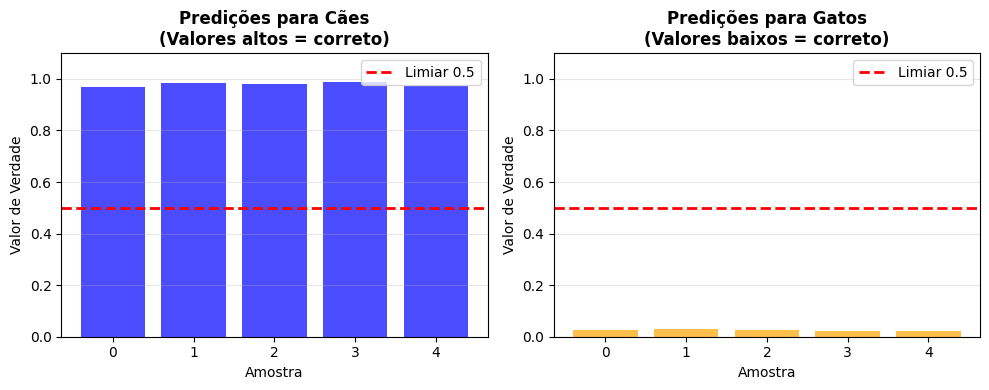

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(5), dog_predictions.value.squeeze().cpu().numpy(), color='blue', alpha=0.7)
plt.title('Predições para Cães\n(Valores altos = correto)', fontsize=12, fontweight='bold')
plt.ylabel('Valor de Verdade')
plt.xlabel('Amostra')
plt.ylim([0, 1.1])
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='Limiar 0.5')
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(5), cat_predictions.value.squeeze().cpu().numpy(), color='orange', alpha=0.7)
plt.title('Predições para Gatos\n(Valores baixos = correto)', fontsize=12, fontweight='bold')
plt.ylabel('Valor de Verdade')
plt.xlabel('Amostra')
plt.ylim([0, 1.1])
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='Limiar 0.5')
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()